Files already downloaded and verified
Files already downloaded and verified
(44000, 32, 32, 3)
(47000, 32, 32, 3)


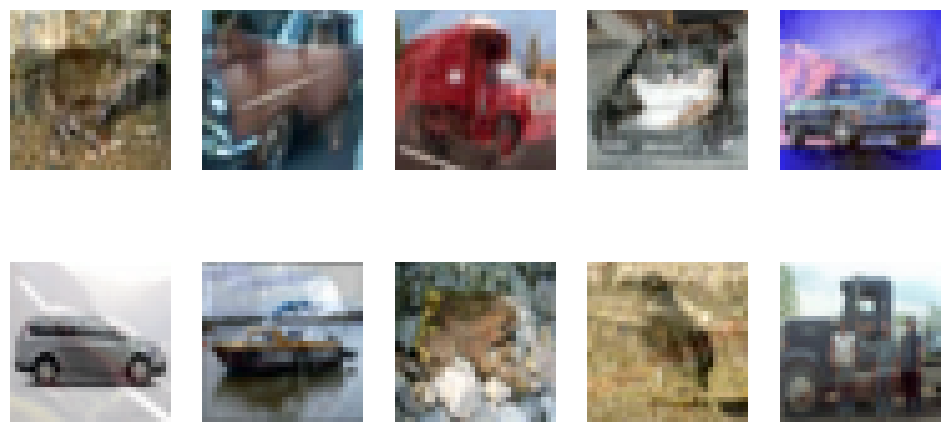

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from PIL import Image

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# 加载 CIFAR-10 数据集
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# 获取每个类别的索引
class_indices = {i: [idx for idx, label in enumerate(trainset.targets) if label == i] for i in range(10)}

# 随机选择标签为不属于这两个类的类
def get_random_label(exclude_labels):
    label_pool = list(set(range(10)) - set(exclude_labels))
    return random.choice(label_pool)

# 将 numpy 数组转换为 PIL 图像
def np_to_pil(np_img):
    return Image.fromarray(np_img)

# 将 PIL 图像转换为 numpy 数组
def pil_to_np(pil_img):
    return np.array(pil_img)

# 从这两个类中各随机选择图片，设置透明度并覆盖，然后将其从数据集中删除
num_new_samples = 3000
new_images = []
new_labels = []
used_indices = set()
alpha = 0.75  # 透明度

for _ in range(num_new_samples):
    class_a, class_b = random.sample(range(10), 2)
    
    idx_a = random.choice(class_indices[class_a])
    idx_b = random.choice(class_indices[class_b])
    
    # 确保不重复使用图片
    while idx_a in used_indices:
        idx_a = random.choice(class_indices[class_a])
    while idx_b in used_indices:
        idx_b = random.choice(class_indices[class_b])
    
    used_indices.add(idx_a)
    used_indices.add(idx_b)
    
    image_a = trainset.data[idx_a]
    image_b = trainset.data[idx_b]
    
    # 转换为 PIL 图像
    image_a = np_to_pil(image_a)
    image_b = np_to_pil(image_b).convert("RGBA")
    
    # 设置透明度
    overlay = image_b.copy()
    overlay.putalpha(int(255 * alpha))
    
    # 将有透明度的图片覆盖到另一张图片上
    new_image = Image.alpha_composite(image_a.convert("RGBA"), overlay).convert("RGB")
    new_images.append(pil_to_np(new_image))
    
    # 设置新标签
    new_label = get_random_label([class_a, class_b])
    new_labels.append(new_label)

# 删除拼接所用的图片
remaining_indices = list(set(range(len(trainset))) - used_indices)
trainset.data = trainset.data[remaining_indices]
trainset.targets = [trainset.targets[i] for i in remaining_indices]
print(trainset.data.shape)

# 将新生成的图片添加到训练集中
new_images = np.array(new_images)
trainset.data = np.concatenate((trainset.data, new_images), axis=0)
print(trainset.data.shape)
trainset.targets.extend(new_labels)

# 创建数据加载器
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

# 随机输出十张拼接后的图片以查看效果
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    idx = len(trainset) - num_new_samples + i
    image = trainset.data[idx]
    image = (image - image.min()) / (image.max() - image.min())  # 归一化到0-1范围
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()


In [12]:
# 指定使用 GPU 0 卡
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义 ResNet-18 模型
model = resnet18(num_classes=10)
model = model.to(device)  # 将模型移动到 GPU

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 训练模型
def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)  # 将数据移动到 GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:  # 每 100 个批次输出一次
            print(f'Epoch [{epoch+1}], Step [{batch_idx+1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

# 测试模型
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)  # 将数据移动到 GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')
    return accuracy

# 训练和测试循环
num_epochs = 30
best_acc = 0.0
for epoch in range(num_epochs):
    train(epoch)
    acc = test()
    
    # 保存表现最好的模型
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), f'{num_new_samples}_{alpha}_best_model.pth')
        print(f'Model saved with accuracy: {acc:.2f}%')

Epoch [1], Step [100/470], Loss: 2.9805
Epoch [1], Step [200/470], Loss: 2.0034
Epoch [1], Step [300/470], Loss: 1.8297
Epoch [1], Step [400/470], Loss: 1.6782
Accuracy of the model on the 10000 test images: 43.81%
Model saved with accuracy: 43.81%
Epoch [2], Step [100/470], Loss: 1.5575
Epoch [2], Step [200/470], Loss: 1.5172
Epoch [2], Step [300/470], Loss: 1.4713
Epoch [2], Step [400/470], Loss: 1.4812
Accuracy of the model on the 10000 test images: 54.25%
Model saved with accuracy: 54.25%
Epoch [3], Step [100/470], Loss: 1.3556
Epoch [3], Step [200/470], Loss: 1.3247
Epoch [3], Step [300/470], Loss: 1.2750
Epoch [3], Step [400/470], Loss: 1.2535
Accuracy of the model on the 10000 test images: 59.60%
Model saved with accuracy: 59.60%
Epoch [4], Step [100/470], Loss: 1.1806
Epoch [4], Step [200/470], Loss: 1.1737
Epoch [4], Step [300/470], Loss: 1.1748
Epoch [4], Step [400/470], Loss: 1.1393
Accuracy of the model on the 10000 test images: 62.67%
Model saved with accuracy: 62.67%
Epoc